# Filtering data based on QC parameters

In [1]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from sklearn.utils import shuffle
from adjustText import adjust_text
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import statsmodels.api as sm
import anndata as AnnData
import scrublet as scr
import pandas as pd
import numpy as np
import cellrank as cr
import seaborn as sns
import scvelo as scv
import scanpy as sc
import matplotlib
import networkx
import fsspec
import igraph
import scvi
import desc 
import umap
import h5py
import os


# Setting the figure parameters
sc.set_figure_params(figsize=(2.2, 2.2))
sc.settings.verbosity = 3 
plt.rcParams.update({'font.size': 9}) 
%load_ext rpy2.ipython
%matplotlib inline     
np.random.seed(42)


Global seed set to 0
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


... reading from cache file cache/Users-brendamelano-Desktop-Reprogramming_Osteosarcoma-Perturb_seq_analysis-OS384-OS384_pert.h5ad


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


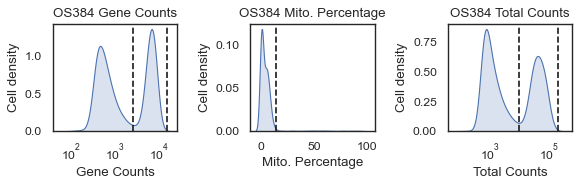

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:554: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["gene_count_corr"] = np.round(


Normalized count data: X, spliced, unspliced.


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html 

Extracted 3000 highly variable genes.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/var/folders/lt/nhcx288j6jjfg45n3bhh1mjh0000gn/T/ipykernel_65335/569408928.py:88: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(adata)
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Use

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    292 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    374 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
regressing out ['n_counts', 'pct_counts_mt', 'ccdifference']
    sparse input is densified and may lead to high memory use


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


    finished (0:00:09)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


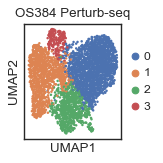

In [2]:
# Reading in loom file. Needed for RNA velocity
adata = scv.read('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS384/OS384_pert.loom', cache = True)


# Making the var names unique
adata.var_names_make_unique()


# Filtering as is done in Seurat
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'


# Computing mitochondrial percentage
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


# Creating df for thresholds for different variables
variables = [
    ('n_genes_by_counts', [(2500, '--'), (15000, '--')]),
    ('pct_counts_mt', [(14, '--')]),
    ('total_counts', [(10000, '--'), (200000, '--')])
]


# Dictionary for new titles
titles = {
    'n_genes_by_counts': 'Gene Counts',
    'pct_counts_mt': 'Mito. Percentage',
    'total_counts': 'Total Counts'
}


# Setting the theme without gridlines
sns.set_theme(style="white")


# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(7.5, 2.5))


# Iterate over the variables and their respective lines to plot
for ax, (var, lines) in zip(axes, variables):
    sns.kdeplot(data=adata.obs, x=var, fill=True, alpha=0.2, ax=ax,
                log_scale=True if var != 'pct_counts_mt' else False)
    for line, style in lines:
        ax.axvline(x=line, color='k', linestyle=style)
    ax.set_title(f"OS384 {titles[var]}")  # Simpler title without extra text
    ax.set_xlabel(titles[var])  # Optionally keep the x-label as the new title
    ax.set_ylabel("Cell density")


# Adjust layout to prevent overlap
plt.tight_layout()


# Save the figure as SVG
#plt.savefig("/Users/brendamelano/Desktop/OS384_pert_filtering.svg")


# Show the plot
plt.show()


# Filtering the adata set based on total counts, genes and mitochondrial percentage
adata = adata[(adata.obs['total_counts'] >= 10000) &
                        (adata.obs['total_counts'] <= 200000) &
                        (adata.obs['n_genes_by_counts'] >= 2500) &
                        (adata.obs['n_genes_by_counts'] < 15000) & #pct_counts_mt
                        (adata.obs['pct_counts_mt'] < 14)
                        ]


#scv.pp.filter_genes(adata, min_shared_counts=20)


# Normalizing the cells by all counts across all the genes
scv.pp.normalize_per_cell(adata)


# filtering the dataset to only keep the most variable genes
# this is redundant to selecting highly variable genes
scv.pp.filter_genes_dispersion(adata, n_top_genes=3000)
# previously at 3000
# 5000 for testing KD


# Make sure that the log transformation is where it belongs in this preprocessing sequence
scv.pp.log1p(adata)


# making the adata copy below might have to go before the log transformation


# preserving the counts
adata.layers["counts"] = adata.X.copy() 


# Freezing the data in raw
adata.raw = adata


# Creating a df with the indexes (CellIDs from the adata object)
sample_one_index = pd.DataFrame(adata.obs.index)


# Selecting highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000, 
    subset=True,
    layer="counts"
)

# 3000 for normal analysis
# 5000 for tesing KD


genes = adata.var.index.values


# reading in cell cycle genes in case I want to regress on that
cell_cycle_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/scvi/regev_lab_cell_cycle_genes.txt')]


# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]


# Keeping the cell cycle genes within the adata object
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]


# Computing cell cycle scores
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)


# Computing ccdifference
adata.obs['ccdifference'] = adata.obs['S_score'] - adata.obs['G2M_score']


#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#adata.raw = adata


# Filtering the df for the most variable genes
adata = adata[:, adata.var.highly_variable]


# Regressing out the total number of counts, mitochondrial percentage and ccdifference scores
sc.pp.regress_out(adata, ['n_counts', 'pct_counts_mt', 'ccdifference'])


# Remove scaling for testing KD
sc.pp.scale(adata, max_value=10)


# Performing dimensionality reduction with PCA
sc.tl.pca(adata, svd_solver='arpack')


# Identifying neighbors for umap
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=10)
sc.tl.umap(adata)


# Leiden clustering
sc.tl.leiden(adata, resolution = 0.25)


# Create a figure and a set of subplots
fig, ax = plt.subplots()


# Plot the UMAP
sc.pl.umap(
    adata,
    color=["leiden"],
    title="OS384 Perturb-seq",
    size=20,
    show=False,  # Prevents the immediate display of the plot
    ax=ax  # Directs the plot to the axes object created earlier
)


# Use tight_layout to adjust the spacing
plt.tight_layout()


# Save the plot as an SVG file
#plt.savefig("/Users/brendamelano/Desktop/OS384_perturbseq_umap_plot.svg", format='svg')


# After saving, you can also display the plot if you wish
plt.show()

In [3]:
# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS384/OS384_perturbseq_adata_leiden_PCA.h5ad")


# Reading in cluster labeled object

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


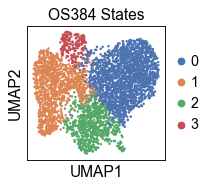

In [2]:
# Reading in the adata file from the subtype data
adata = scv.read("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS384/OS384_perturbseq_adata_leiden_PCA.h5ad")


# Plot the UMAP
sc.pl.umap(
    adata,
    color=["leiden"],
    frameon=True,
    title="OS384 States",
    size=20,
    show=False  # Do not display the plot immediately
)


# Rasterize the scatter plot elements only
ax = plt.gca()
for artist in ax.get_children():
    if isinstance(artist, mc.PathCollection):  # Use the correct module path
        artist.set_rasterized(True)

        
# Save as an SVG with rasterized points
#plt.savefig("/Users/brendamelano/Desktop/OS384_pert_clusters_rasterized.svg", format='svg')
plt.show()

# Reading in state-labeled object

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'OS384 States'}, xlabel='UMAP1', ylabel='UMAP2'>

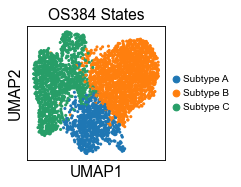

In [8]:
# Reading in the adata file from the subtype data
adata = scv.read("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS384/OS384_perturbseq_adata_state_labeled.h5ad")



# Plotting based on UMAP
sc.pl.umap(adata, 
           color=['State'], 
           legend_fontsize=9, 
           title="OS384 States",
           show=False)  # Prevent the figure from displaying immediately


# Save the figure manually to Desktop
#plt.savefig('/Users/brendamelano/Desktop/UMAP_OS152_State.svg', format='svg', dpi=300)


# Module score enrichment

computing score 'State_A_score'
    finished: added
    'State_A_score', score of gene set (adata.obs).
    99 total control genes are used. (0:00:00)
computing score 'State_B_score'
    finished: added
    'State_B_score', score of gene set (adata.obs).
    147 total control genes are used. (0:00:00)
computing score 'Subtype_C_score'
    finished: added
    'Subtype_C_score', score of gene set (adata.obs).
    50 total control genes are used. (0:00:00)


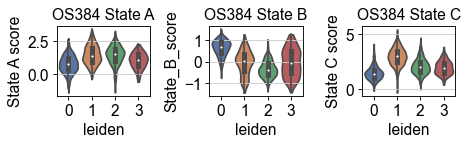

In [3]:
# Reading in gene lists for GSEA
Subtype_A_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/gmt_files/State_A_module_NMF.csv')]
Subtype_B_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/gmt_files/State_B_module_NMF.csv')]
Subtype_C_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/gmt_files/State_C_module_NMF.csv')]


# Keeping only genes that appear in the adata
Subtype_A_genes = [x for x in Subtype_A_genes if x in adata.var_names]
Subtype_B_genes = [x for x in Subtype_B_genes if x in adata.var_names]
Subtype_C_genes = [x for x in Subtype_C_genes if x in adata.var_names]


# Computing GSEA scores
sc.tl.score_genes(adata, Subtype_A_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='State_A_score', random_state=0, copy=False, use_raw=None)
sc.tl.score_genes(adata, Subtype_B_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='State_B_score', random_state=0, copy=False, use_raw=None)
sc.tl.score_genes(adata, Subtype_C_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='Subtype_C_score', random_state=0, copy=False, use_raw=None)


# Plotting the results
fig, axs = plt.subplots(1, 3, figsize=(5.7, 1.9))

sc.pl.violin(adata, ['State_A_score'], groupby='leiden', stripplot=False, inner='box', 
             ylabel='State A score', ax=axs[0], show=False)

axs[0].set_title('OS384 State A')

sc.pl.violin(adata, ['State_B_score'], groupby='leiden', stripplot=False, inner='box', 
             ylabel='State_B_score', ax=axs[1], show=False)
axs[1].set_title('OS384 State B')

sc.pl.violin(adata, ['Subtype_C_score'], groupby='leiden', stripplot=False, inner='box', 
             ylabel='State C score', ax=axs[2], show=False)
axs[2].set_title('OS384 State C')

plt.tight_layout()


# Saving the figure onto the desktop
plt.savefig('/Users/brendamelano/Desktop/OS384_perturb_seq_gsea_scores.svg', format='svg')
plt.show()



# Assigning each cluster to a state

In [7]:

# Extracting the state scores
score_df = adata.obs[['leiden', 'State_A_score', 'State_B_score', 'Subtype_C_score']].copy()


# Mean scores per cluster
mean_scores = score_df.groupby('leiden')[['State_A_score', 'State_B_score', 'Subtype_C_score']].mean()


# Smaller rank means a higher score (rank=1 is the highest mean score)
ranked_scores = mean_scores.rank(method='dense', ascending=False, axis=0) 


# Assign each cluster the state with the highest mean state module enrichment score (same as lowest rank score)
cluster_state_assignment = ranked_scores.idxmin(axis=1)


# 
adata.obs['dominant_state'] = adata.obs['leiden'].map(cluster_state_assignment.to_dict())


cluster_state_assignment


leiden
0    State_B_score
1    State_A_score
2    State_A_score
3    State_B_score
dtype: object

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/var/folders/lt/nhcx288j6jjfg45n3bhh1mjh0000gn/T/ipykernel_14300/65902242.py:47: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_subset.var['subtype_order'] = adata_su

<Figure size 1200x300 with 0 Axes>

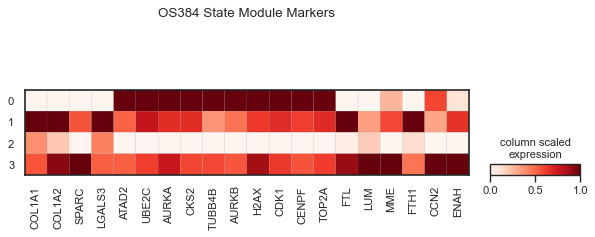

In [5]:
# Read gene lists for each subtype from the CSV files
def read_genes(file_path):
    with open(file_path, 'r') as file:
        genes = [x.strip() for x in file]
    return genes


# Reading in the subtype gene modules
Subtype_A_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/Subtype_A_module.csv')
Subtype_B_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/Subtype_B_module.csv')
Subtype_C_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/Subtype_C_module.csv')


# Specified markers for visualization
specified_genes = ['UBE2C', 'AURKA', 'CENPF', 'AURKB', 'CKS2', 'TOP2A', 'CDK1', 'TUBB4B', 'ATAD2', 'H2AX']

# Ensure these genes are in the adata object
reduced_state_B_genes = [gene for gene in specified_genes if gene in adata.var_names]

plt.rcParams.update({'font.size': 12})

# Combine gene lists from all subtypes, ensuring uniqueness if necessary
combined_genes = list(set(Subtype_A_genes + reduced_state_B_genes + Subtype_C_genes))


# Keeping only genes that appear in the adata object
combined_genes = [gene for gene in combined_genes if gene in adata.var_names]


# Ensure the combined_genes are in your expression data
adata_subset = adata[:, adata.var_names.isin(combined_genes)]


# Create the subtype dictionary 
subtype_A_dict = {gene: 'A' for gene in Subtype_A_genes}
subtype_B_dict = {gene: 'B' for gene in reduced_state_B_genes}
subtype_C_dict = {gene: 'C' for gene in Subtype_C_genes}
subtype_dict = {**subtype_A_dict, **subtype_B_dict, **subtype_C_dict}


# Annotate the genes in adata with their subtype
adata.var['State'] = [subtype_dict.get(gene, 'Unknown') for gene in adata.var_names]


# Sort the genes based on the state module they belong to
adata_subset = adata[:, adata.var_names.isin(combined_genes)]
adata_subset.var['subtype_order'] = adata_subset.var['State'].map({'A': 1, 'B': 2, 'C': 3, 'Unknown': 4})
adata_subset = adata_subset[:, adata_subset.var['subtype_order'].argsort()]


# Create a list of genes sorted by subtype for use in the matrixplot
sorted_genes_by_subtype = adata_subset.var_names.tolist()


# Create a figure explicitly
plt.figure(figsize=(2, 0.5), dpi=600) 


ax = sc.pl.matrixplot(
    adata_subset,
    var_names=sorted_genes_by_subtype,  # Use the sorted list of genes
    groupby='leiden',
    cmap="Reds",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    title="OS384 State Module Markers",
    show=False
)


# Save the figure using matplotlib's savefig with explicit format setting
plt.savefig("/Users/brendamelano/Desktop/OS384_cluster_markers.svg", format='svg')

plt.show()

plt.close()


# GSEA

computing score 'IL2_genes_score'
    finished: added
    'IL2_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'MTOR_genes_score'
    finished: added
    'MTOR_genes_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'FOCAL_ADHESION_PI3KAKTMTOR_genes_score'
    finished: added
    'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', score of gene set (adata.obs).
    195 total control genes are used. (0:00:00)
computing score 'PDGF_ERK1_DOWN_genes_score'
    finished: added
    'PDGF_ERK1_DOWN_genes_score', score of gene set (adata.obs).
    147 total control genes are used. (0:00:00)
computing score 'TNFA_genes_score'
    finished: added
    'TNFA_genes_score', score of gene set (adata.obs).
    150 total control genes are used. (0:00:00)


computing score 'GCNP_genes_score'
    finished: added
    'GCNP_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'CSR_genes_score'
    finished: added
    'CSR_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'ESC_genes_score'
    finished: added
    'ESC_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'STK33_genes_score'
    finished: added
    'STK33_genes_score', score of gene set (adata.obs).
    190 total control genes are used. (0:00:00)
computing score 'VEGFA_genes_score'


    finished: added
    'VEGFA_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'KRAS_genes_score'
    finished: added
    'KRAS_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'TGFB_genes_score'
    finished: added
    'TGFB_genes_score', score of gene set (adata.obs).
    149 total control genes are used. (0:00:00)
computing score 'EMT_genes_score'
    finished: added
    'EMT_genes_score', score of gene set (adata.obs).
    148 total control genes are used. (0:00:00)
computing score 'EZH2_genes_score'
    finished: added
    'EZH2_genes_score', score of gene set (adata.obs).
    196 total control genes are used. (0:00:00)
computing score 'LEF1_genes_score'
    finished: added
    'LEF1_genes_score', score of gene set (adata.obs).
    190 total control genes are used. (0:00:00)


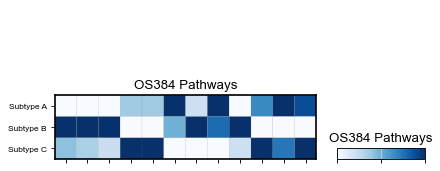

In [4]:
# Define the directory for the gmt files
directory = '/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/gmt_files'


# Create a dictionary to store gene lists
gene_lists = {}


# Create variables for gene lists
for filename in os.listdir(directory):
    
    # identifying the txt files
    if filename.endswith('.txt'):
        variable_name = os.path.splitext(filename)[0].upper()
        variable_name += "_genes"
        with open(os.path.join(directory, filename)) as f:
            gene_lists[variable_name] = [line.strip() for line in f]

            
# Create a dictionary to store gene scores for each module
gene_scores = {}


# Quantify enrichment for each gene list
for gene_list_name, gene_list in gene_lists.items():
    scores_key = gene_list_name + "_score"
    try:
        gene_scores[gene_list_name] = sc.tl.score_genes(
            adata, gene_list, ctrl_size=50, gene_pool=None,
            n_bins=5, score_name=scores_key, random_state=0, 
            copy=False, use_raw=None
        )
    except KeyError:
        continue

        
adata.var_names_make_unique()


# Defining the score names
scores = ['MTOR_genes_score', 'GCNP_genes_score', 'CSR_genes_score',   
          'LEF1_genes_score','ESC_genes_score','TNFA_genes_score',
          'PDGF_ERK1_DOWN_genes_score', 'KRAS_genes_score', 'TGFB_genes_score',
          'IL2_genes_score',  'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', 'STK33_genes_score',]


# Plotting the pathway matrix plot based on subtype
axes_dict = sc.pl.matrixplot(
    adata,
    scores,
    "State",
    dendrogram=False,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    show=False  # This prevents the plot from showing immediately
)


# Remove the x-axis labels
for ax in axes_dict.values():
    ax.set_xticklabels([])  # Remove x-axis labels
    ax.set_title('OS384 Pathways', fontsize=12)

    
# Save the figure. Ensure that all parts of the figure are on the same figure object
plt.gcf().savefig('/Users/brendamelano/Desktop/OS384_Perturbseq_Pathways.svg', format='svg')  # Adjust path as needed


# Show the plot if desired
plt.show()

# State labeling

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


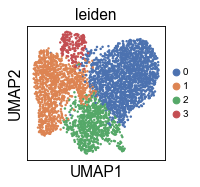

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


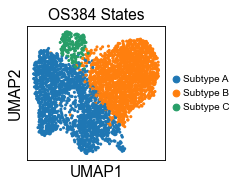

In [6]:
sc.pl.umap(adata, color=['leiden'], legend_fontsize=9, size = 20)


# Changing the leiden column to a category type
adata.obs['leiden'] = adata.obs['leiden'].astype('category')



adata.obs['leiden'][adata.obs['leiden']=='1']='2'


# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'Subtype A': ['2'],  'Subtype B': ['0'], 'Subtype C':['3']}


# Initialize empty column in cell metadata
adata.obs['State'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden).isin(cell_dict[i])
    adata.obs.loc[ind,'State'] = i

    
# creating a dataframe with the cluster IDs
subtypes = pd.DataFrame(adata.obs['State'].values)


# Define the number of clusters
n_subtypes = len(subtypes[0].unique())


# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_subtypes)


# Create a dictionary that maps each cluster ID to a color from the palette
#subtype_colors = dict(zip(sorted(subtypes[0].unique()), colors))


# Map the cluster IDs to their corresponding colors
#adata.uns['subtype_colors'] = [subtype_colors[c] for c in subtypes[0]]

sc.pl.umap(adata, color=['State'], legend_fontsize=9, 
           title = "OS384 States") #, palette = subtype_colors


# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS384/OS384_perturbseq_adata_state_labeled.h5ad")

#adata = sc.read("/Users/brendamelano/Desktop/OS152_adata_labeled.h5ad")

In [ ]:
# Create the UMAP plot
sc.pl.umap(adata, color=['State'], legend_fontsize=9, 
           title="OS384 States", show=False)  # Use show=False to prevent display

# Defining desktop name
desktop_path = '/Users/brendamelano/Desktop/' 
file_name = 'OS384_States_UMAP.svg'      

# Access the current figure
fig = plt.gcf()

# Save as rasterized SVG
fig.savefig(desktop_path + file_name, format='svg', dpi=300, rasterized=True)

# Optionally, close the figure to free up memory
plt.close(fig)

# RNA velocity

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on distances
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/12 cores)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1202 [00:00<?, ?gene/s]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.or

    finished (0:06:44) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/3803 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2084: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


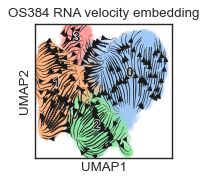

In [4]:
# computing the moments
scv.pp.moments(adata, mode = 'distances')
 

# recovering dynamics
scv.tl.recover_dynamics(adata)

# inferring the DYNAMIC velocities
scv.tl.velocity(adata, mode='dynamical')


# computing the velocity graph
scv.tl.velocity_graph(adata)

# creating a dataframe with the cluster IDs
clusters = pd.DataFrame(adata.obs['leiden'].astype('int64').values)

# Define the number of clusters
n_clusters = len(clusters[0].unique())

# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_clusters)

# Create a dictionary that maps each cluster ID to a color from the palette
cluster_colors = dict(zip(sorted(clusters[0].unique()), colors))

# Map the cluster IDs to their corresponding colors
adata.uns['ClusterName_colors'] = [cluster_colors[c] for c in clusters[0]]

# Set the plot style to 'white' to remove grid lines
sns.set_style('white')


# Plot the stream with the discrete color legend
scv.pl.velocity_embedding_stream(adata, basis='umap', 
                                 color='leiden', 
                                 palette=colors, 
                                 title = 'OS384 RNA velocity embedding',
                                 frameon = True)

# Labeling each cell with its TF target

In [3]:
# For loom files
adata.obs.index = adata.obs.index.str.replace('OS384_pert:', '').str.replace('x', '') + '-1'


### Reading in mol info data from wynton
# Reading in the macthed cell barcodes and guides that were generated in wynton
molecular_data = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS384/OS384_molecular_data.csv', index_col=0) 


# Keep only the 'feature_ids' and 'cell_barcodes' columns
molecular_data = molecular_data[['feature_ids', 'cell_barcodes']]


molecular_data['feature_ids'] = molecular_data['feature_ids'].str.strip("b''")
molecular_data['feature_ids'] = molecular_data['feature_ids'].str.replace(r'(-1i|-2i)$', '', regex=True)


# removing the b'' string from cell barcodes
molecular_data['cell_barcodes'] = molecular_data['cell_barcodes'].str.strip("b''")


# Remove duplicate rows across the entire DataFrame
molecular_data_unique = molecular_data.drop_duplicates()


# 
molecular_data_unique['cell_barcodes'] = molecular_data_unique['cell_barcodes'].apply(lambda x: f"{x}-1")


# Setting the cell_barcodes column to the index column
molecular_data_unique = molecular_data_unique.set_index('cell_barcodes')


adata.obs = adata.obs.assign(cell_barcode=adata.obs.index)


adata.obs['Gene'] = "NT-ctrl"


for barcode in molecular_data_unique.index:
    if barcode in adata.obs.index:
        # If barcode exists in AnnData, add/update gene info in .obs
        # Example: Add a concatenated string of genes to a new column, handling duplicates
        genes = molecular_data_unique.loc[barcode, 'feature_ids']
        gene_str = ', '.join(genes) if isinstance(genes, pd.Series) else genes
        adata.obs.at[barcode, 'Gene'] = gene_str
    else:
        # If barcode does not exist, add a new entry (optional, depends on your analysis needs)
        # You might need to handle adding new cells to `.X` or other attributes depending on your data structure
        genes = 'NT-ctrl'
        
        
# Filter observations where 'Gene' column does not contain a comma
adata = adata[~adata.obs['Gene'].str.contains(',')].copy()


# Convert 'feature_ids' column to string
#adata['feature_ids'] = adata['feature_ids'].astype(str)


# Filter rows where 'feature_ids' column contains the string "LT"
#filtered_data = merged_data[merged_data['feature_ids'].str.contains("LT", na=False)]


# Define a function that replaces any string containing 'control' with 'control'
def replace_with_control(gene_string):
    if 'NT-ctrl' in gene_string:
        return 'NT-ctrl'
    else:
        return gene_string

    
# Apply the function to the 'Gene' column
adata.obs['Gene'] = adata.obs['Gene'].apply(replace_with_control)

kd_counts = adata.obs['Gene'].value_counts()

kd_counts

NT-ctrl    54
NFE2L3     39
TCF4       38
IRF1       37
STAT1      26
NR0B1      18
JUN        14
NFKB2      14
TSHZ2      12
Name: Gene, dtype: int64

# Regulome score

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Parse .gmt file
def parse_gmt(gmt_path):
    with open(gmt_path, 'r') as f:
        regulome = [line.strip().split('\t')[2:] for line in f]
    return regulome[0]  # Assuming one regulome set per file

# Load the NFE2L3 regulome
gmt_path = "/Users/brendamelano/Desktop/gmt_files/TF_regulomes/NFE2L3_TARGET_GENES.gmt"
nfe2l3_genes = parse_gmt(gmt_path)

# Make a copy of the raw data
adata_raw = adata.raw.to_adata()

# Compute regulome enrichment scores using the raw data
sc.tl.score_genes(adata_raw, gene_list=nfe2l3_genes, score_name='NFE2L3_score')


# Add the computed scores to the main adata object
adata.obs['NFE2L3_score'] = adata_raw.obs['NFE2L3_score']

# Debugging: Check the unique values in the 'Group' column
print("Unique values in 'Group':", adata.obs['Group'].unique())

# Filter adata.obs to exclude the "Other" category
subset_obs = adata.obs[adata.obs['Group'].isin(['NT-ctrl', 'NFE2L3'])]

# Debugging: Check the sizes of each group
print("Counts for NT-ctrl:", (subset_obs['Group'] == 'NT-ctrl').sum())
print("Counts for NFE2L3 KD:", (subset_obs['Group'] == 'NFE2L3').sum())

# Extract scores for statistical testing
ctrl_scores = subset_obs.loc[subset_obs['Group'] == 'NT-ctrl', 'NFE2L3_score'].dropna()
nfe2l3_scores = subset_obs.loc[subset_obs['Group'] == 'NFE2L3', 'NFE2L3_score'].dropna()

# Debugging: Check sizes of score arrays
print("Size of ctrl_scores:", ctrl_scores.shape[0])
print("Size of nfe2l3_scores:", nfe2l3_scores.shape[0])

# Perform Mann-Whitney U Test only if both groups are non-empty
if ctrl_scores.shape[0] > 0 and nfe2l3_scores.shape[0] > 0:
    stat, p_value = mannwhitneyu(ctrl_scores, nfe2l3_scores, alternative='two-sided')
    print(f"Mann-Whitney U Test statistic: {stat}, p-value: {p_value:.2e}")

    # Create violin plot using Seaborn
    plt.figure(figsize=(6, 4))
    sns.violinplot(data=subset_obs, x='Group', y='NFE2L3_score', palette='Set2', inner='box')
    sns.swarmplot(data=subset_obs, x='Group', y='NFE2L3_score', color='k', alpha=0.5, size=3)

    # Annotate p-value on the plot
    x1, x2 = 0, 1  # positions for the groups
    y, h, col = subset_obs['NFE2L3_score'].max() + 0.1, 0.05, 'k'
    plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
    plt.text((x1 + x2) * 0.5, y + h + 0.02, f'p = {p_value:.2e}', ha='center', va='bottom', fontsize=12, color=col)

    # Final plot adjustments
    plt.title("Regulome Enrichment Scores: NFE2L3", fontsize=14)
    plt.xlabel("Group", fontsize=12)
    plt.ylabel("Enrichment Score", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(False)  # Remove gridlines
    plt.tight_layout()
    plt.show()
else:
    print("Error: One or both groups have zero scores. Skipping Mann-Whitney U Test.")

computing score 'NFE2L3_score'
    finished: added
    'NFE2L3_score', score of gene set (adata.obs).
    99 total control genes are used. (0:00:00)


# confirming KD

computing score 'NFE2L3_score'
    finished: added
    'NFE2L3_score', score of gene set (adata.obs).
    99 total control genes are used. (0:00:00)
Unique values in 'Group': ['Other' 'NFE2L3 KD' 'NT-ctrl']
Counts for NT-ctrl: 54
Counts for NFE2L3 KD: 39
Size of ctrl_scores: 54
Size of nfe2l3_scores: 39
Mann-Whitney U Test statistic: 1269.0, p-value: 9.34e-02
Plot saved to /Users/brendamelano/Desktop/NFE2L3_regulome_violin_plot_adjusted.svg


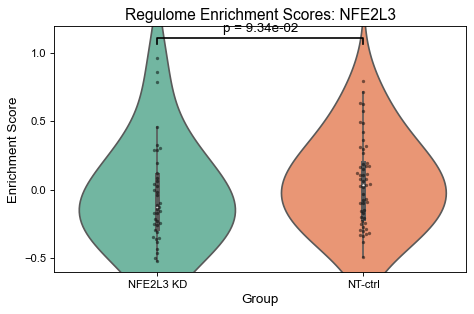

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Parse .gmt file
def parse_gmt(gmt_path):
    with open(gmt_path, 'r') as f:
        regulome = [line.strip().split('\t')[2:] for line in f]
    return regulome[0]  # Assuming one regulome set per file

# Load the NFE2L3 regulome
gmt_path = "/Users/brendamelano/Desktop/gmt_files/TF_regulomes/NFE2L3_TARGET_GENES.gmt"
nfe2l3_genes = parse_gmt(gmt_path)

# Make a copy of the raw data
adata_raw = adata.raw.to_adata()

# Compute regulome enrichment scores using the raw data
sc.tl.score_genes(adata_raw, gene_list=nfe2l3_genes, score_name='NFE2L3_score')

# Add the computed scores to the main adata object
adata.obs['NFE2L3_score'] = adata_raw.obs['NFE2L3_score']

# Add group labels
adata.obs['Group'] = 'Other'
adata.obs.loc[adata.obs['Gene'] == 'NT-ctrl', 'Group'] = 'NT-ctrl'
adata.obs.loc[adata.obs['Gene'] == 'NFE2L3', 'Group'] = 'NFE2L3 KD'

# Debugging: Check the unique values in the 'Group' column
print("Unique values in 'Group':", adata.obs['Group'].unique())

# Filter adata.obs to exclude the "Other" category
subset_obs = adata.obs[adata.obs['Group'].isin(['NT-ctrl', 'NFE2L3 KD'])]

# Debugging: Check the sizes of each group
print("Counts for NT-ctrl:", (subset_obs['Group'] == 'NT-ctrl').sum())
print("Counts for NFE2L3 KD:", (subset_obs['Group'] == 'NFE2L3 KD').sum())

# Extract scores for statistical testing
ctrl_scores = subset_obs.loc[subset_obs['Group'] == 'NT-ctrl', 'NFE2L3_score'].dropna()
nfe2l3_scores = subset_obs.loc[subset_obs['Group'] == 'NFE2L3 KD', 'NFE2L3_score'].dropna()

# Debugging: Check sizes of score arrays
print("Size of ctrl_scores:", ctrl_scores.shape[0])
print("Size of nfe2l3_scores:", nfe2l3_scores.shape[0])

# Perform Mann-Whitney U Test only if both groups are non-empty
if ctrl_scores.shape[0] > 0 and nfe2l3_scores.shape[0] > 0:
    stat, p_value = mannwhitneyu(ctrl_scores, nfe2l3_scores, alternative='two-sided')
    print(f"Mann-Whitney U Test statistic: {stat}, p-value: {p_value:.2e}")

    # Create violin plot using Seaborn
    plt.figure(figsize=(6, 4))
    sns.violinplot(data=subset_obs, x='Group', y='NFE2L3_score', palette='Set2', inner='box', bw=0.8)
    sns.swarmplot(data=subset_obs, x='Group', y='NFE2L3_score', color='k', alpha=0.5, size=3)

    # Annotate p-value on the plot
    x1, x2 = 0, 1  # positions for the groups
    y, h, col = subset_obs['NFE2L3_score'].max() + 0.1, 0.05, 'k'
    plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
    plt.text((x1 + x2) * 0.5, y + h + 0.02, f'p = {p_value:.2e}', ha='center', va='bottom', fontsize=12, color=col)

    # Center the violins by adjusting x-axis limits
    plt.xlim(-0.5, 1.5)

    # Final plot adjustments
    plt.title("Regulome Enrichment Scores: NFE2L3", fontsize=14)
    plt.xlabel("Group", fontsize=12)
    plt.ylabel("Enrichment Score", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(False)  # Remove gridlines

    # Save the plot as SVG to Desktop
    save_path = "/Users/brendamelano/Desktop/NFE2L3_regulome_violin_plot_adjusted.svg"
    plt.tight_layout()
    plt.savefig(save_path, format="svg", dpi=300)
    print(f"Plot saved to {save_path}")

    # Show the plot
    plt.show()
else:
    print("Error: One or both groups have zero scores. Skipping Mann-Whitney U Test.")


# Checking that the kd worked

In [9]:
def plot_gene_expression(adata, gene, output_path=None):
    """
    Generates box plot and density plot for a given gene using the specified AnnData object.

    Parameters:
    adata (AnnData): The annotated data matrix.
    gene (str): Target gene to plot.
    output_path (str): Optional path to save the plots as SVG files. If None, plots are displayed instead.
    """
    # Check if the gene is present in the dataset
    if gene not in adata.var_names:
        raise ValueError(f"Gene '{gene}' not found in the AnnData object.")
    
    # Separate the control and gene-specific data
    adata_ctrl = adata[adata.obs['Gene'] == 'NT-ctrl']
    adata_gene = adata[adata.obs['Gene'] == gene]

    # Extract expression values for the target gene
    ctrl_expression = adata_ctrl[:, gene].X.flatten()
    gene_expression = adata_gene[:, gene].X.flatten()

    # Ensure non-empty data
    if len(ctrl_expression) == 0 or len(gene_expression) == 0:
        raise ValueError("Expression data is empty for one of the groups.")
    
    # Mann-Whitney U test
    u_stat, p_value = mannwhitneyu(ctrl_expression, gene_expression, alternative='two-sided')

    # Prepare data for box plot
    data_to_plot = [ctrl_expression, gene_expression]

    # Box Plot
    plt.figure(figsize=(3, 2.5))
    plt.boxplot(data_to_plot, widths=0.4, patch_artist=True,
                medianprops={'color': 'black'},
                boxprops={'facecolor': 'lightblue'},
                whiskerprops={'color': 'blue'},
                capprops={'color': 'blue'})
    
    # Customize plot with labels
    plt.xticks([1, 2], ['NT-ctrl', gene])
    plt.xlabel('Group')
    plt.ylabel('Expression Levels')
    plt.title(f'{gene} Expression')
    
    # Annotate with p-value
    plt.text(1.5, max(np.concatenate(data_to_plot)) - 0.2, f'p-value = {p_value:.2e}', ha='center', va='bottom')
    plt.tight_layout()
    
    # Save box plot if path is provided
    if output_path:
        plt.savefig(f'{output_path}/{gene}_expression_boxplot.svg', format='svg')
    else:
        plt.show()

    plt.close()

    # Histogram / Density Plot
    plt.figure(figsize=(2.2, 2.3))

    # Create density plots
    sns.kdeplot(ctrl_expression, color='skyblue', fill=True, alpha=0.5, label='NT-ctrl')
    sns.kdeplot(gene_expression, color='lightpink', fill=True, alpha=0.5, label=gene)

    plt.title(f'Density Plot for {gene}')
    plt.xlabel('Expression Level')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()

    # Save density plot if path is provided
    if output_path:
        plt.savefig(f'{output_path}/{gene}_density_plot.svg', format='svg')
    else:
        plt.show()

    plt.close()
    
    
# Assuming 'adata' is your AnnData object and 'NFE2L3' is the gene of interest
plot_gene_expression(adata, 'NFE2L3', output_path='/Users/brendamelano/Desktop')

# Generating state and target df for modeling

In [8]:
# Extracting the required columns
df = adata.obs[['Gene', 'State']]


# Creating one-hot encoding for the Gene column
one_hot = pd.get_dummies(df['Gene'])
df = df.join(one_hot)


# Adding a 'cell_line' column with all values as 'OS384'
df['cell_line'] = 'OS384'


df = df.drop(columns=['Gene'])



# Saving the DataFrame
df.to_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS384/OS384_Subtype_target_for_modeling.csv')



In [28]:

# Reading the DataFrame back in to ensure it was saved correctly
loaded_df = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS384/OS384_Subtype_target_for_modeling.csv', index_col='CellID')
OS742_df = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS742/OS742_Subtype_target_for_modeling.csv', index_col='CellID')
OS833_df = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS833/OS833_Subtype_target_for_modeling.csv', index_col='CellID')

# Adjusting columns for consistency
OS833_df.columns.values[0] = 'State'
OS742_df.columns.values[0] = 'State'


# Combining DataFrames
combined_df = pd.concat([loaded_df, OS742_df, OS833_df])
combined_df['State'] = combined_df['State'].str.replace('Subtype', 'State', regex=False)


# Removing JUNB because absent in one cell line (NAs)
combined_df = combined_df.drop(columns=['JUNB'])

combined_df

# Binary logistic regression

Optimization terminated successfully.
         Current function value: 0.563404
         Iterations 6


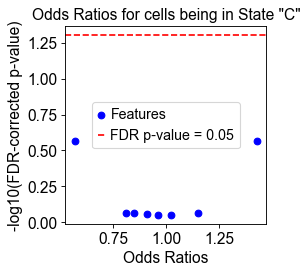

In [34]:
# Shuffling the combined DataFrame
shuffled_df = shuffle(combined_df)


# Preparing data for multinomial logistic regression
X = shuffled_df.drop(columns=['State', 'NT-ctrl'])  # Removing 'NT-ctrl' to use as reference, 'State' is the target
y = shuffled_df['State']
X = pd.get_dummies(X, drop_first=True)  # One-hot encoding for categorical variables including 'cell_line'


# Creating a binary variable for being in 'State B'
shuffled_df['State_Binary'] = (shuffled_df['State'] == 'State C').astype(int)
y_binary = shuffled_df['State_Binary']


# Handling NaNs or infinite values
if np.any(np.isnan(X)) or np.any(np.isinf(X)):
    print("Data contains NaNs or infinite values")
    X = X.fillna(0)


# Fitting binary logistic regression
model = sm.Logit(y_binary, sm.add_constant(X))
result = model.fit()



# Getting the summary of the model to check significant coefficients
summary_df = result.summary2().tables[1]

# Removing 'cell_line' coefficients and the constant
filters = summary_df.index.str.contains("cell_line") | (summary_df.index == 'const')
summary_df = summary_df[~filters]


# Calculating -log10 of the p-values
summary_df['neg_log_pvalue'] = -np.log10(summary_df['P>|z|'])

# Calculating odds ratios
summary_df['odds_ratio'] = np.exp(summary_df['Coef.'])

# FDR correction
_, fdr_corrected_pvals, _, _ = multipletests(summary_df['P>|z|'], method='fdr_bh')
summary_df['FDR_corrected_pvalue'] = fdr_corrected_pvals
summary_df['neg_log_fdr_pvalue'] = -np.log10(summary_df['FDR_corrected_pvalue'])

# Setting significance threshold
fdr_threshold = -np.log10(0.05)


# Plotting Odds Ratios vs. -log10(FDR-corrected p-value)
plt.figure(figsize=(3.5, 3.5))  # Increased figure size for better visibility
plt.scatter(summary_df['odds_ratio'], summary_df['neg_log_fdr_pvalue'], color='b', label='Features')
plt.axhline(fdr_threshold, color='red', linestyle='--', label='FDR p-value = 0.05')
plt.xlabel('Odds Ratios')
plt.ylabel('-log10(FDR-corrected p-value)')
plt.title('Odds Ratios for cells being in State "C"')

# Removing gridlines
plt.grid(False)

# Collect all annotations in a list
texts = []

# Annotate only significant points
for i, txt in enumerate(summary_df.index):
    if summary_df['neg_log_fdr_pvalue'].iloc[i] > fdr_threshold:
        x = summary_df['odds_ratio'].iloc[i]
        y = summary_df['neg_log_fdr_pvalue'].iloc[i]
        texts.append(plt.text(x, y, txt, fontsize=10, weight='bold'))

# Adjust text positions to prevent overlapping
adjust_text(
    texts,
    expand_text=(1.05, 1.2),
    expand_points=(1.2, 1.2),
    arrowprops=dict(arrowstyle='-', color='gray', lw=0.5)
)

plt.legend()
plt.tight_layout()


# Display the plot
plt.savefig("/Users/brendamelano/Desktop/perturb_seq_plot_odds_ratios_FDR_corrected_TF_highlight_State_C.svg", format='svg')  
plt.show()

Optimization terminated successfully.
         Current function value: 0.622951
         Iterations 5


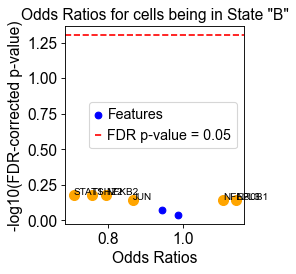

In [33]:
# Shuffling the combined DataFrame
shuffled_df = shuffle(combined_df)


# Preparing data for multinomial logistic regression
X = shuffled_df.drop(columns=['State', 'NT-ctrl'])  # Removing 'NT-ctrl' to use as reference, 'State' is the target
y = shuffled_df['State']
X = pd.get_dummies(X, drop_first=True)  # One-hot encoding for categorical variables including 'cell_line'


# Creating a binary variable for being in 'State B'
shuffled_df['State_Binary'] = (shuffled_df['State'] == 'State B').astype(int)
y_binary = shuffled_df['State_Binary']


# Handling NaNs or infinite values
if np.any(np.isnan(X)) or np.any(np.isinf(X)):
    print("Data contains NaNs or infinite values")
    X = X.fillna(0)


# Fitting binary logistic regression
model = sm.Logit(y_binary, sm.add_constant(X))
result = model.fit()



# Getting the summary of the model to check significant coefficients
summary_df = result.summary2().tables[1]

# Removing 'cell_line' coefficients and the constant
filters = summary_df.index.str.contains("cell_line") | (summary_df.index == 'const')
summary_df = summary_df[~filters]


# Calculating -log10 of the p-values
summary_df['neg_log_pvalue'] = -np.log10(summary_df['P>|z|'])

# Calculating odds ratios
summary_df['odds_ratio'] = np.exp(summary_df['Coef.'])

# FDR correction
_, fdr_corrected_pvals, _, _ = multipletests(summary_df['P>|z|'], method='fdr_bh')
summary_df['FDR_corrected_pvalue'] = fdr_corrected_pvals
summary_df['neg_log_fdr_pvalue'] = -np.log10(summary_df['FDR_corrected_pvalue'])

# Setting significance threshold
fdr_threshold = -np.log10(0.05)

# Sorting the DataFrame to get the top 3 points with the highest FDR-corrected p-values
top3 = summary_df.nsmallest(6, 'FDR_corrected_pvalue')

# Plotting Odds Ratios vs. -log10(FDR-corrected p-value)
plt.figure(figsize=(3.5, 3.5))  # Increased figure size for better visibility
plt.scatter(summary_df['odds_ratio'], summary_df['neg_log_fdr_pvalue'], color='b', label='Features')
plt.axhline(fdr_threshold, color='red', linestyle='--', label='FDR p-value = 0.05')
plt.xlabel('Odds Ratios')
plt.ylabel('-log10(FDR-corrected p-value)')
plt.title('Odds Ratios for cells being in State "B"')

# Highlighting the top 3 points with the highest p-values
plt.scatter(top3['odds_ratio'], top3['neg_log_fdr_pvalue'], color='orange', s=80)

# Annotating the top 3 points
for i, txt in enumerate(top3.index):
    x = top3['odds_ratio'].iloc[i]
    y = top3['neg_log_fdr_pvalue'].iloc[i]
    plt.text(x, y, txt, fontsize=9)

# Removing gridlines
plt.grid(False)

# Collect all annotations for other significant points
texts = []

# Annotate only significant points other than the top 3
for i, txt in enumerate(summary_df.index):
    if summary_df['neg_log_fdr_pvalue'].iloc[i] > fdr_threshold and txt not in top3.index:
        x = summary_df['odds_ratio'].iloc[i]
        y = summary_df['neg_log_fdr_pvalue'].iloc[i]
        texts.append(plt.text(x, y, txt, fontsize=10, weight='bold'))

# Adjust text positions to prevent overlapping
adjust_text(
    texts,
    expand_text=(1.05, 1.2),
    expand_points=(1.2, 1.2),
    arrowprops=dict(arrowstyle='-', color='gray', lw=0.5)
)

plt.legend()
plt.tight_layout()

# Display the plot
plt.savefig("/Users/brendamelano/Desktop/perturb_seq_plot_odds_ratios_FDR_corrected_TF_highlight.svg", format='svg')  
plt.show()

In [4]:
print(summary_df.columns)


Index(['State = 0', 'Coef.', 'Std.Err.', 't', 'P>|t|', '[0.025', '0.975]'], dtype='object')


$$
\log\left( \frac{P(\text{State} = k)}{P(\text{State} = \text{'NT-ctrl'})} \right) = \beta_{0k} + \beta_{1k} \times \text{TF_1} + \beta_{2k} \times \text{TF_2} + \beta_{Nk} \times \text{TF_N} + \gamma_k \times \text{Cell line}
$$

# State proportions after TF perturbations

In [ ]:
adata.obs

In [30]:
adata.obs['State'] = adata.obs['State'].str.replace('Subtype', 'State', regex=False)

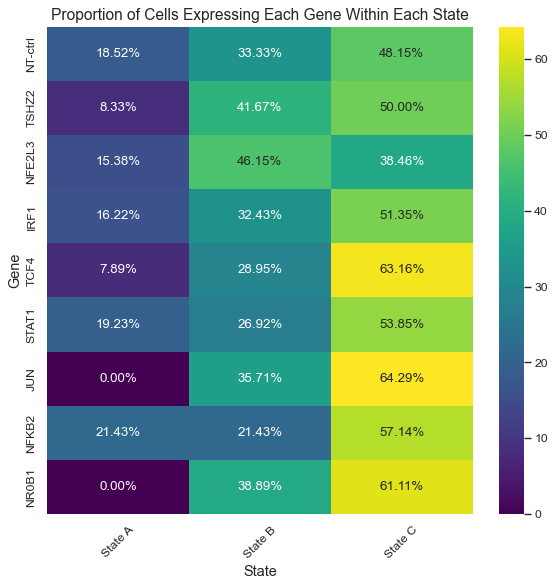

In [31]:
clusters_sorted = sorted(adata.obs['State'].unique())
gene_clusters = pd.DataFrame(columns=clusters_sorted)

# First, ensure 'NT-ctrl' is included at the beginning of the genes list
unique_genes = np.append('NT-ctrl', adata.obs['Gene'].unique())

# Fill the DataFrame
for gene in unique_genes:
    percentages = []
    gene_total = (adata.obs['Gene'] == gene).sum()  # Total cells expressing the gene across all clusters
    if gene_total == 0:  # Handle 'NT-ctrl' and any gene not found to avoid division by zero
        percentages = [0 for _ in clusters_sorted]
    else:
        for cluster in clusters_sorted:
            gene_in_cluster = ((adata.obs['Gene'] == gene) & (adata.obs['State'] == cluster)).sum()
            prop_gene_in_cluster = gene_in_cluster / gene_total  # Proportion of cells in this cluster for the gene
            percentages.append(prop_gene_in_cluster)
    gene_clusters.loc[gene] = percentages

    
# Convert to percentages
gene_clusters *= 100

# Convert each value to a string with a percentage sign for annotation
gene_clusters_str = gene_clusters.applymap(lambda x: "{:.2f}%".format(x))

# Plotting the heatmap
plt.figure(figsize=(7.5,7.5))
sns.heatmap(gene_clusters, annot=gene_clusters_str, fmt="s", cmap='viridis')
plt.title('Proportion of Cells Expressing Each Gene Within Each State', fontsize=14)
plt.ylabel('Gene', fontsize=13)
plt.xlabel('State', fontsize=13)
plt.xticks(rotation=45)
plt.tight_layout()


# Adjust the file path for saving the figure as needed
plt.savefig('/Users/brendamelano/Desktop/OS384_Percent_in_State_per_target.svg', format='svg')


plt.show()

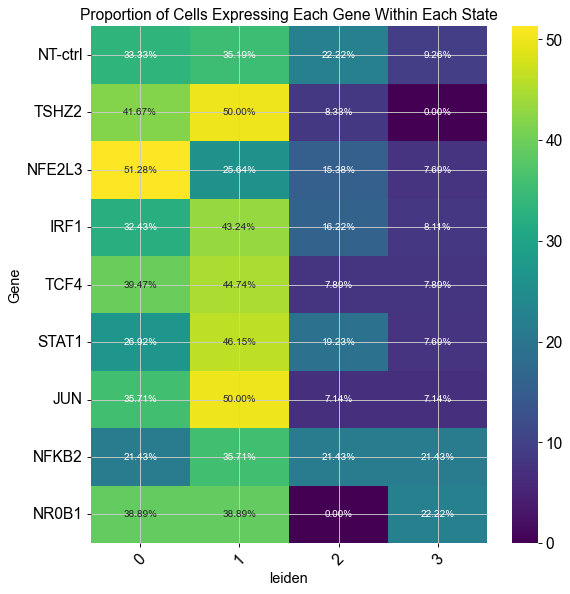

In [4]:
clusters_sorted = sorted(adata.obs['leiden'].unique())
gene_clusters = pd.DataFrame(columns=clusters_sorted)

# including 'NT-ctrl' at the beginning of the gene list
unique_genes = np.append('NT-ctrl', adata.obs['Gene'].unique())


# Fill the DataFrame
for gene in unique_genes:
    percentages = []
    gene_total = (adata.obs['Gene'] == gene).sum()  # Total cells expressing the gene across all clusters
    if gene_total == 0:  # Handle 'NT-ctrl' and any gene not found to avoid division by zero
        percentages = [0 for _ in clusters_sorted]
    else:
        for cluster in clusters_sorted:
            gene_in_cluster = ((adata.obs['Gene'] == gene) & (adata.obs['leiden'] == cluster)).sum()
            prop_gene_in_cluster = gene_in_cluster / gene_total  # Proportion of cells in this cluster for the gene
            percentages.append(prop_gene_in_cluster)
    gene_clusters.loc[gene] = percentages

    
# Convert to percentages
gene_clusters *= 100


# Convert each value to a string with a percentage sign for annotation
gene_clusters_str = gene_clusters.applymap(lambda x: "{:.2f}%".format(x))


# Plotting the heatmap
plt.figure(figsize=(7.5,7.5))
sns.heatmap(gene_clusters, annot=gene_clusters_str, fmt="s", cmap='viridis')
plt.title('Proportion of Cells Expressing Each Gene Within Each State', fontsize=14)
plt.ylabel('Gene', fontsize=13)
plt.xlabel('leiden', fontsize=13)
plt.xticks(rotation=45)
plt.tight_layout()


# Adjust the file path for saving the figure as needed
plt.savefig('/Users/brendamelano/Desktop/OS384_Percent_in_State_per_target.svg', format='svg')


plt.show()

# Visualizing cells from a certain target

In [16]:
adata.obs['NFE2L3'] = pd.Categorical(adata.obs['Gene'].apply(lambda x: 1 if x == 'TCF4' else 0))


adata = adata[adata.obs['NFE2L3'].sort_values(ascending=False).index]

# Define a custom color palette where 'False' is gray and 'True' is the default color (e.g., orange)
custom_palette = ['#808080', 'orange']  # gray for 'False', orange for 'True'

# Reorder data so that 'True' values are plotted last (on top)
adata_temp = adata[adata.obs['NFE2L3'].sort_values().index]


# Plot the UMAP with the custom color palette and increased dot size
sc.pl.umap(adata_temp, color='NFE2L3', palette=custom_palette, 
           add_outline=True, s=30, title='OS384 NFE2L3 perturbed cells')

# ,        save = "OS384_depleted_barcodes.svg"

# DGEA

In [9]:
def perform_dge_analysis_and_visualize_heatmap(adata, gene_of_interest, control='NT-ctrl', output_file='/Users/brendamelano/Desktop/heatmap.svg'):
    # Filter the data for the specified gene and control
    adata_filtered = adata[adata.obs['Gene'].isin([control, gene_of_interest])].copy()

    # Create a grouping variable
    adata_filtered.obs['group'] = adata_filtered.obs['Gene']

    # Perform differential gene expression analysis directly comparing 'control' vs the specified gene
    sc.tl.rank_genes_groups(adata_filtered, groupby='group', groups=[gene_of_interest], reference=control)

    # Access the differential expression results
    results = adata_filtered.uns['rank_genes_groups']

    # Extract the names, log fold changes, and p-values for the specified gene group
    gene_names = results['names'][gene_of_interest]
    logfoldchanges = results['logfoldchanges'][gene_of_interest]
    pvals = results['pvals'][gene_of_interest]
    pvals_adj = results['pvals_adj'][gene_of_interest]

    # Create a DataFrame
    df = pd.DataFrame({
        'Gene': gene_names,
        'Log2 fold change': logfoldchanges,
        'P-value': pvals,
        'Adjusted P-value': pvals_adj
    })

    # Filter the DataFrame for significant log fold changes and adjusted p-values
    significant_genes = df[((df['Log2 fold change'] > 1) | (df['Log2 fold change'] < -1)) & (df['Adjusted P-value']< 0.05)]

    # Check if significant_genes is empty
    if significant_genes.empty:
        print("No significant genes found with the given criteria.")
        return df  # Return the full dataframe for further inspection

    # Normalize the data
    sc.pp.scale(adata_filtered)

    # Ensure only the specified groups are included
    adata_filtered.obs['group'] = pd.Categorical(
        adata_filtered.obs['group'],
        categories=[control, gene_of_interest]
    )

    # Create the matrixplot for all genes in the group
    ax = sc.pl.matrixplot(
        adata_filtered,
        var_names=significant_genes['Gene'],
        groupby='group',
        cmap="Blues",
        standard_scale="var",
        colorbar_title="column scaled\nexpression",
        title=f"{gene_of_interest} perturbation DEGs",
        show=False  # Do not display the plot immediately
    )

    # Set the title
    plt.title(f"{gene_of_interest} perturbation DEGs")

    # Save the plot as an SVG file
    plt.savefig(output_file, format='svg')

    # Show the plot
    plt.show()

    return significant_genes

# Example usage
significant_genes = perform_dge_analysis_and_visualize_heatmap(adata, gene_of_interest='NFE2L3')

ranking genes


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
No significant genes found with the given criteria.


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devd

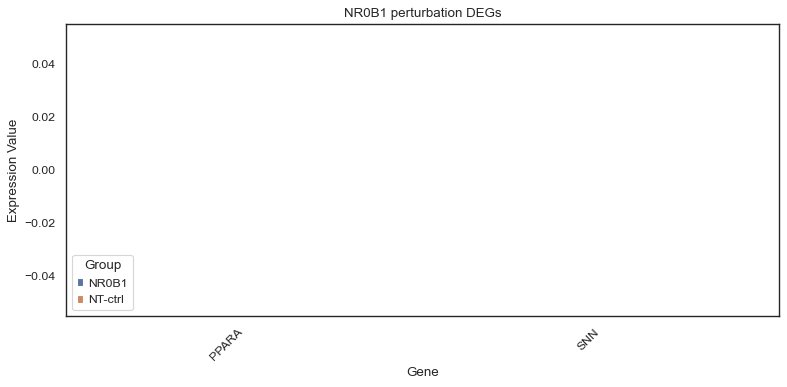

,Gene,Log2 fold change,P-value,Adjusted P-value
0,PPARA,1.614577,0.000012,0.034145
4999,SNN,-28.020033,0.000014,0.034145


In [13]:
perform_dge_analysis_and_visualize_barchart(adata, gene_of_interest='NR0B1')

In [6]:
significant_genes 

,Gene,Log2 fold change,P-value,Adjusted P-value
0,CAV1,1.187517,0.000035,0.174838
1,GCNT4,2.870707,0.000299,0.341055
2,ANGPT1,4.062885,0.000429,0.341055
3,MDK,0.887756,0.000253,0.341055
4,EDIL3,1.089757,0.000355,0.341055
...,...,...,...,...
4995,ABCA1,-3.207512,0.003460,0.407789
4996,ENSG00000233470,-26.688406,0.003712,0.412478
4997,CCNA1,-27.354717,0.002820,0.399568
4998,PLA2G4C,-2.874851,0.002162,0.371919


In [4]:
# Example usage (assuming 'adata' is your AnnData object):
results_df = perform_dge_analysis(adata, 'NFE2L3', 'NT-ctrl')
print(results_df)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
No significant genes found with the given criteria.
                 Gene  Log2 fold change   P-value  Adjusted P-value
0                CAV1          1.187517  0.000035          0.174838
1               GCNT4          2.870707  0.000299          0.341055
2              ANGPT1          4.062885  0.000429          0.341055
3                 MDK          0.887756  0.000253          0.341055
4               EDIL3          1.089757  0.000355          0.341055
...               ...               ...       ...               ...
4995            ABCA1         -3.207512  0.003460          0.407789
4996  ENSG0000023347

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devd

In [23]:
unique_genes = adata.obs['Gene'].unique().tolist()
non_control_genes = [gene for gene in unique_genes if gene != 'control']

In [25]:
# Read the CSV file into a DataFrame
Subtype_B = pd.read_csv('/Users/brendamelano/Desktop/gmt_files/Subtype_B_module.csv')


# If you need to convert the DataFrame column to a list (optional)
Subtype_B = Subtype_B['Gene'].tolist()

In [27]:
top_genes_per_comparison = []

In [31]:
group_counts = adata.obs['Gene'].value_counts()


# Filter out groups with only one sample
valid_groups = group_counts[group_counts > 1].index.tolist()


# Optionally, remove 'JUNB' explicitly if present
if 'JUNB' in valid_groups:
    valid_groups.remove('JUNB')

# Initialize the list to store top genes per comparison
top_genes_per_comparison = []

for target_gene in non_control_genes:
    # Check if the target_gene is in valid_groups before proceeding
    if target_gene in valid_groups:
        # Filter the data for 'control' and the current non-control gene
        adata_filtered = adata[adata.obs['Gene'].isin(['control', target_gene])].copy()
        adata_filtered.obs['group'] = adata_filtered.obs['Gene']

        # Perform differential gene expression analysis
        sc.tl.rank_genes_groups(adata_filtered, groupby='group', groups=[target_gene], reference='control')

        # Extract the top 40 genes
        results = adata_filtered.uns['rank_genes_groups']
        top_genes = results['names'][target_gene][:40]

        # Store the top 40 genes for this comparison
        top_genes_per_comparison.append((target_gene, top_genes.tolist()))
    else:
        print(f"Skipping {target_gene}: not enough samples or explicitly excluded.")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be i